# New York City Taxi Fare Prediction - Feature Engineering + Keras

In this Project, I used all 55 million records. After every manipulation with features I had to save and relaunch my dataframes, because I had many issues with memory. I will skip this steps in my notebook. 

In [1]:
# load Python modules

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

C:\Users\FZ_DarkSider\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load main Dataset

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> This training dataset has 7 columns with 55423855 records, what takes 3.2 GB of memory. 

In [3]:
df = pd.read_csv('train.csv')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54367523 entries, 0 to 55423855
Data columns (total 7 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
dtypes: float64(5), object(2)
memory usage: 3.2+ GB


# Check for 0 and NaN

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> As we have a lot of data, I decided drop all zero values and NaN values from dataset before any features manipulation.

In [8]:
print('NaN values:')
print('key:',df.key.isnull().sum())
print('fare_amount:',df.fare_amount.isnull().sum())
print('pickup_datetime:',df.pickup_datetime.isnull().sum())
print('pickup_longitude:',df.pickup_longitude.isnull().sum())
print('pickup_latitude:',df.pickup_latitude.isnull().sum())
print('dropoff_longitude:',df.dropoff_longitude.isnull().sum())
print('dropoff_latitude:',df.dropoff_latitude.isnull().sum())
print("--------------------------")
print('Zerro values')
print('key:',(df.key == 0).sum())
print('fare_amount:',(df.fare_amount == 0).sum())
print('pickup_datetime:',(df.pickup_datetime == 0).sum())
print('pickup_longitude:',(df.pickup_longitude == 0).sum())
print('pickup_latitude:',(df.pickup_latitude == 0).sum())
print('dropoff_longitude:',(df.dropoff_longitude == 0).sum())
print('dropoff_latitude:',(df.dropoff_latitude == 0).sum())

NaN values:
key: 0
fare_amount: 0
pickup_datetime: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 376
dropoff_latitude: 376
--------------------------
Zerro values
key: 0
fare_amount: 1380
pickup_datetime: 0
pickup_longitude: 1055693
pickup_latitude: 1052158
dropoff_longitude: 1052745
dropoff_latitude: 1049666


In [9]:
# Drop all zerros and NaN's
df.dropna(inplace=True)

In [10]:
df = df.loc[df.fare_amount != 0]

In [ ]:
df = df.loc[df.pickup_longitude != 0]

In [ ]:
df = df.loc[df.pickup_latitude != 0]

In [ ]:
df = df.loc[df.dropoff_longitude != 0]

In [ ]:
df = df.loc[df.dropoff_latitude != 0]

# Drop passenger_count

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> As we can see most rides with only one passenger, and also number of passengers almost never affect the price, so I decided drop this features to free up some memory.

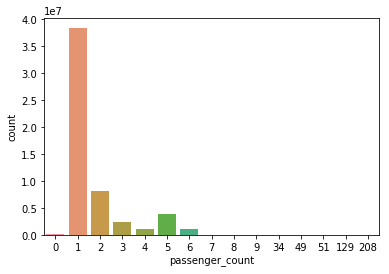

In [35]:
g = sns.countplot(df.passenger_count)

In [ ]:
df.drop('passenger_count', axis=1, inplace=True)

# Check correlation on raw longitude

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> Here I just decided to check how small correlation between my target and one of the feature first.

In [11]:
check_corr = df[['pickup_longitude', 'fare_amount']].corr()
check_corr

,pickup_longitude,fare_amount
pickup_longitude,1.000000,0.004136
fare_amount,0.004136,1.000000


# Creating features from longitude and latitude

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> I decided create 3 new features from location. I also took Central Park coordinates as center of NYC. 
    
1 - Distance between two points (pickup and dropoff) 

2 - Distance from the center (pickup) 

3 - Distance from the center (dropoff).

In [8]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762


# 1 - Distance

In [98]:
# Use this function to count distance between two points

import math
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [10]:
# Create new column with zeros
df['Distance'] = 0

In [11]:
# Enumerate this column as I gonna use it as index for my apply function
j = -1
for i in range(len(df.Distance)):
    j+=1
    df.Distance.values[i] = j

In [12]:
df.head(4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,3


In [13]:
df.tail(4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
54317894,2009-03-24 20:46:20.0000002,4.2,2009-03-24 20:46:20 UTC,-73.957784,40.765530,-73.951640,40.773959,54317894
54317895,2011-04-02 22:04:24.0000004,14.1,2011-04-02 22:04:24 UTC,-73.970505,40.752325,-73.960537,40.797342,54317895
54317896,2011-10-26 05:57:51.0000002,28.9,2011-10-26 05:57:51 UTC,-73.980901,40.764629,-73.870605,40.773963,54317896
54317897,2014-12-12 11:33:00.00000015,7.5,2014-12-12 11:33:00 UTC,-73.969722,40.797668,-73.970885,40.783313,54317897


In [ ]:
# Apply function distance
df['Distance'] = df.Distance.apply(lambda x: distance((df.pickup_latitude[x], df.pickup_longitude[x]), (df.dropoff_latitude[x], df.dropoff_longitude[x])) if x >= 0 else x)

In [5]:
df.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.999157


# 2 - Distance from the center (pickup)

The latitude of Central Park, New York, NY, USA is 40.785091, and the longitude is -73.968285

In [14]:
def distance_from_center(destination):
    lat1, lon1 = (40.785091, -73.968285)
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [10]:
df['Pick_from_Center'] = 0

In [11]:
j = -1
for i in range(len(df.Pick_from_Center)):
    j+=1
    df.Pick_from_Center.values[i] = j

In [13]:
# Apply function distance_from_center (for pickup)
%%time
df['Pick_from_Center'] = df.Pick_from_Center.apply(lambda x: distance_from_center((df.pickup_latitude[x], df.pickup_longitude[x])) if x >= 0 else x)

Wall time: 35min 4s


# 3 - Distance from the center (dropoff)

In [17]:
df['Drop_from_Center'] = 0

In [19]:
j = -1
for i in range(len(df.Drop_from_Center)):
    j+=1
    df.Drop_from_Center.values[i] = j

In [21]:
# Apply function distance_from_center (dropoff)
%%time
df['Drop_from_Center'] = df.Drop_from_Center.apply(lambda x: distance_from_center((df.dropoff_latitude[x], df.dropoff_longitude[x])) if x >= 0 else x)

Wall time: 34min 32s


# Round values in 3 new features to 1 decimal to save some memory

In [8]:
%%time
df.Distance = df.Distance.apply(lambda x: np.round(x, decimals=1))
df.Pick_from_Center = df.Pick_from_Center.apply(lambda x: np.round(x, decimals=1))
df.Drop_from_Center = df.Drop_from_Center.apply(lambda x: np.round(x, decimals=1))

Wall time: 6min 8s


# Search for outliers

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> I dropped original columns with longitude and latitude. Then I checked for max distance from center and found some big numbers, also fare_amount has few big numbers. I assumed that max distance from the center should be  no longer than 150 and fare abount not more then $2000.

In [7]:
%%time
df = df.loc[df.Pick_from_Center <= 150]

Wall time: 17.2 s


In [9]:
%%time
df = df.loc[df.Drop_from_Center <= 150]

Wall time: 24.9 s


In [12]:
%%time
df = df.loc[df.fare_amount <= 2000]

Wall time: 31.4 s


In [3]:
df.head()

,key,fare_amount,pickup_datetime,Distance,Pick_from_Center,Drop_from_Center
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,1.0,12.6,13.4
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,8.5,9.1,1.0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,1.4,2.9,4.3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,2.8,6.0,3.6
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,2.0,1.9,1.0


In [5]:
df.shape

(54269077, 6)

In [6]:
print('Max fare amount:',df.fare_amount.max())
print('Max distance from center (pickup):',df.Pick_from_Center.max())
print('Max distance from center (dropoff):',df.Drop_from_Center.max())

Max fare amount: 1564.5
Max distance from center (pickup): 149.9
Max distance from center (dropoff): 149.6


# Create new features from pickup date and time

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> Split datetime into 5 different features (hour, day, year, day of week, month). And make some categories.

In [7]:
# Transform into datetime format
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

In [10]:
df['hour'] = 0
df['hour'] = df.pickup_datetime.map(lambda x: x.hour)

In [12]:
df['day'] = 0
df['day'] = df.pickup_datetime.map(lambda x: x.day)

In [14]:
df['year'] = 0
df['year'] = df.pickup_datetime.map(lambda x: x.year)

In [17]:
df['day_of_week'] = 0
df['day_of_week'] = df.pickup_datetime.map(lambda x: x.weekday_name)

In [19]:
df['month'] = 0
df['month'] = df.pickup_datetime.map(lambda x: x.month)

In [5]:
df.drop('pickup_datetime', axis=1, inplace=True)

In [6]:
df.head(5)

,key,fare_amount,Distance,Pick_from_Center,Drop_from_Center,hour,day,year,day_of_week,month
0,2009-06-15 17:26:21.0000001,4.5,1.0,12.6,13.4,17,15,2009,Monday,6
1,2010-01-05 16:52:16.0000002,16.9,8.5,9.1,1.0,16,5,2010,Tuesday,1
2,2011-08-18 00:35:00.00000049,5.7,1.4,2.9,4.3,0,18,2011,Thursday,8
3,2012-04-21 04:30:42.0000001,7.7,2.8,6.0,3.6,4,21,2012,Saturday,4
4,2010-03-09 07:51:00.000000135,5.3,2.0,1.9,1.0,7,9,2010,Tuesday,3


# Check balance of rides for each new features

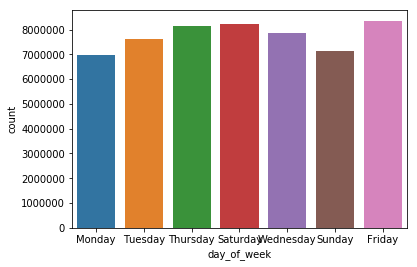

In [9]:
g = sns.countplot(df.day_of_week)

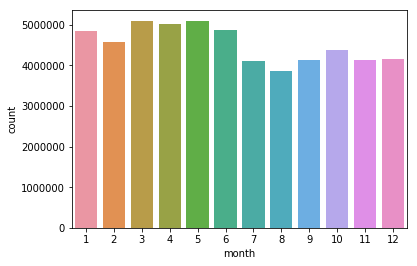

In [10]:
g = sns.countplot(df.month)

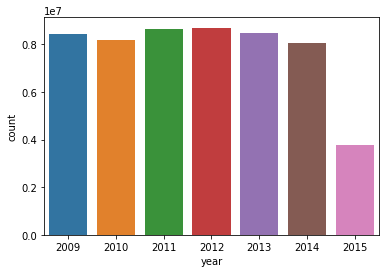

In [11]:
g = sns.countplot(df.year)

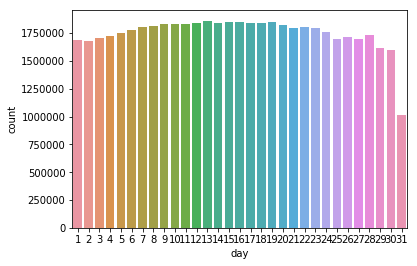

In [12]:
# I checked corelation between price and day, its very small, which is logicaly correct so I will drop this feature
g = sns.countplot(df.day)

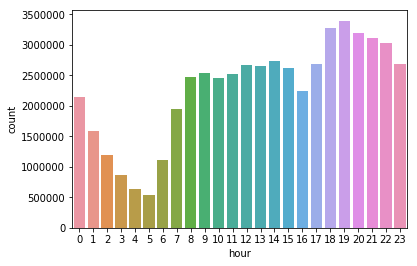

In [13]:
# I will create 3 categories for the time of the day (0-5) (6-17) (18-23)
g = sns.countplot(df.hour) 

In [3]:
# I decided to create 3 categories for day of the week (Mon-Thu) (Fri) (Sat-Sun)
df['day_of_week_n'] = 0
df['day_of_week_n'] =  df['day_of_week'].apply(lambda x: 1 if x == 'Monday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 1 if x == 'Tuesday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 1 if x == 'Wednesday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 1 if x == 'Thursday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 2 if x == 'Friday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 3 if x == 'Saturday' else str(x))
df['day_of_week_n'] =  df['day_of_week_n'].apply(lambda x: 3 if x == 'Sunday' else str(x))

In [9]:
df_main.day_of_week_n = df_main.day_of_week_n.astype(int)

In [5]:
# I take last 2 digits from year to save some memory
df['year_n'] = 0
df['year_n'] =  df['year'].apply(lambda x: 9 if x == 2009 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 10 if x == 2010 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 11 if x == 2011 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 12 if x == 2012 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 13 if x == 2013 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 14 if x == 2014 else int(x))
df['year_n'] =  df['year_n'].apply(lambda x: 15 if x == 2015 else int(x))

In [19]:
# Split time during the day on 3 categories as there pick time for traffic and low time for traffic
df['hour_n'] = 0
df['hour_n'] =  df['hour'].apply(lambda x: 1 if x >= 0 and x <= 5 else int(x))
df['hour_n'] =  df['hour_n'].apply(lambda x: 2 if x > 5 and x <= 17 else int(x))
df['hour_n'] =  df['hour_n'].apply(lambda x: 3 if x > 17 else int(x))

In [8]:
df.head()

,key,fare_amount,Distance,Pick_from_Center,Drop_from_Center,month,day_of_week_n,year_n,hour_n
0,2009-06-15 17:26:21.0000001,4.5,1.0,12.6,13.4,6,1,9,2
1,2010-01-05 16:52:16.0000002,16.9,8.5,9.1,1.0,1,1,10,2
2,2011-08-18 00:35:00.00000049,5.7,1.4,2.9,4.3,8,1,11,1
3,2012-04-21 04:30:42.0000001,7.7,2.8,6.0,3.6,4,3,12,1
4,2010-03-09 07:51:00.000000135,5.3,2.0,1.9,1.0,3,1,10,2


# Check correlation for each new feature with fare

In [13]:
check_corr1 = df[['Distance', 'fare_amount']].corr()
print(check_corr1)
print('----------------------------------------------')
check_corr2 = df[['Pick_from_Center', 'fare_amount']].corr()
print(check_corr2)
print('----------------------------------------------')
check_corr3 = df[['Drop_from_Center', 'fare_amount']].corr()
print(check_corr3)
print('----------------------------------------------')
check_corr4 = df[['month', 'fare_amount']].corr()
print(check_corr4)
print('----------------------------------------------')
check_corr5 = df[['day_of_week_n', 'fare_amount']].corr()
print(check_corr5)
print('----------------------------------------------')
check_corr6 = df[['year_n', 'fare_amount']].corr()
print(check_corr6)
print('----------------------------------------------')
check_corr7 = df[['hour_n', 'fare_amount']].corr()
print(check_corr7)

             Distance  fare_amount
Distance     1.000000     0.755111
fare_amount  0.755111     1.000000
----------------------------------------------
                  Pick_from_Center  fare_amount
Pick_from_Center          1.000000     0.321621
fare_amount               0.321621     1.000000
----------------------------------------------
                  Drop_from_Center  fare_amount
Drop_from_Center           1.00000      0.38099
fare_amount                0.38099      1.00000
----------------------------------------------
                month  fare_amount
month        1.000000     0.024029
fare_amount  0.024029     1.000000
----------------------------------------------
               day_of_week_n  fare_amount
day_of_week_n        1.00000     -0.00183
fare_amount         -0.00183      1.00000
----------------------------------------------
               year_n  fare_amount
year_n       1.000000     0.115361
fare_amount  0.115361     1.000000
------------------------------------

# Go Keras

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> 1. Split dataset into features and target

<span style="color:#1e488f"> 2. Scale features using StandardScaler
    
<span style="color:#1e488f"> 3. Define RMSE function
    
<span style="color:#1e488f"> 4. Set learning_rate_reduction (didn't work at the end :) )
    
<span style="color:#1e488f"> 5. Build model with 3 layers and 128 nodes on each of layer, use adam optimizer, and RMSE metric
    
<span style="color:#1e488f"> 6. For batch size I set 1500 as dataset is too big, and 100 epoch

In [3]:
df_mail = pd.read_csv('Final.csv')

In [4]:
df_mail.head(2)

,key,fare_amount,Distance,Pick_from_Center,Drop_from_Center,month,day_of_week_n,year_n,hour_n
0,2009-06-15 17:26:21.0000001,4.5,1.0,12.6,13.4,6,1,9,2
1,2010-01-05 16:52:16.0000002,16.9,8.5,9.1,1.0,1,1,10,2


In [5]:
features = df_mail.iloc[:, 2:].values
features.shape

(54269077, 7)

In [6]:
target = df_mail['fare_amount'].values
target.shape

(54269077,)

In [7]:
new_standart = StandardScaler()
featuresS = new_standart.fit_transform(features)

In [8]:
# define RMSE function
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [9]:
# I was trying to use learning rate reduction but it didn't work in this case.
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [10]:
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_shape=(featuresS.shape[1],)))
model2.add(Dense(128, activation='relu', input_shape=(featuresS.shape[1],)))
model2.add(Dense(128, activation='relu', input_shape=(featuresS.shape[1],)))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

In [11]:
model2.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])

In [12]:
model2.fit(featuresS, target, epochs=100, batch_size=1500, verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/100
54269077/54269077 [==============================] - 274s 5us/step - loss: 19.1512 - root_mean_squared_error: 2.0391
Epoch 2/100
   28500/54269077 [..............................] - ETA: 1:46:44 - loss: 19.0701 - root_mean_squared_error: 2.0259

C:\Users\FZ_DarkSider\Anaconda3\lib\site-packages\keras-2.2.0-py3.6.egg\keras\callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,root_mean_squared_error,lr


54269077/54269077 [==============================] - 287s 5us/step - loss: 17.6773 - root_mean_squared_error: 1.9467
Epoch 3/100
54269077/54269077 [==============================] - 259s 5us/step - loss: 17.4141 - root_mean_squared_error: 1.9264
Epoch 4/100
54269077/54269077 [==============================] - 252s 5us/step - loss: 17.2724 - root_mean_squared_error: 1.9160
Epoch 5/100
54269077/54269077 [==============================] - 254s 5us/step - loss: 17.1972 - root_mean_squared_error: 1.9101
Epoch 6/100
54269077/54269077 [==============================] - 262s 5us/step - loss: 17.1303 - root_mean_squared_error: 1.9058
Epoch 7/100
54269077/54269077 [==============================] - 251s 5us/step - loss: 17.0923 - root_mean_squared_error: 1.9026
Epoch 8/100
54269077/54269077 [==============================] - 260s 5us/step - loss: 17.0598 - root_mean_squared_error: 1.9003
Epoch 9/100
54269077/54269077 [==============================] - 254s 5us/step - loss: 17.0264 - root_mean_sq

# Apply my model into test part and create submission dataframe

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> I prepeared my test data in the same way as my training set.

In [14]:
df_test = pd.read_csv('test_ready.csv')

In [15]:
df_test.head()

,key,Distance,Pick_from_Center,Drop_from_Center,month,day_of_week_n,year_n,hour_n
0,2015-01-27 13:08:24.0000002,2.3,2.4,4.7,1,1,15,2
1,2015-01-27 13:08:24.0000003,2.4,7.5,5.7,1,1,15,2
2,2011-10-08 11:53:44.0000002,0.6,3.9,4.4,10,3,11,2
3,2012-12-01 21:12:12.0000002,2.0,2.2,4.2,12,3,12,3
4,2012-12-01 21:12:12.0000003,5.4,0.6,4.8,12,3,12,3


In [16]:
features2 = df_test.iloc[:, 1:].values
features2.shape

(9914, 7)

In [17]:
new_standart = StandardScaler()
featuresS_test = new_standart.fit_transform(features2)

In [18]:
pred_test = model2.predict(featuresS_test)

In [19]:
submission = pd.DataFrame({ 'key': df_test.key.values,
                            'fare_amount': pred_test.ravel() })

In [20]:
submission = submission[['key', 'fare_amount']]

In [21]:
submission.to_csv('submission2.csv', index=False)

# Conclusion

<span style="color:#be0119"><b>
--- comment ---</b>

<span style="color:#1e488f"> It was very interesting to go through this task, and as I used all data from this dataset I had many issues with my PC (lost of count how many times I restarted my PC). I was thinking to get more features from location but due resources limitation I skip it. I thought to create features which could give me understanding if car is moving to the center or from the city and create different categories depends of time of the day. Because traffic during the day is different, and very important where you are driving into center or out of city. 

RMSE = 1.8722